# Import Libraries

In [2]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score, recall_score, f1_score,classification_report
import numpy as np
import seaborn as sns
import random
import time
import copy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import seaborn as sns
sns.set_style("whitegrid")

In [4]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

print(torch.cuda.is_available())

True


In [5]:
batch_size = 64

data_path = '/kaggle/input/plantdisease/PlantVillage'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [9]:
leaf_datasets.classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [10]:
class_mapping = {
    'Pepper__bell___Bacterial_spot': 'PBBS',
    'Pepper__bell___healthy': 'PBH',
    'Potato___Early_blight': 'PEB',
    'Potato___Late_blight': 'PLB',
    'Potato___healthy': 'PH',
    'Tomato_Bacterial_spot': 'TBS',
    'Tomato_Early_blight': 'TEB',
    'Tomato_Late_blight': 'TLB',
    'Tomato_Leaf_Mold': 'TLM',
    'Tomato_Septoria_leaf_spot': 'TSLS',
    'Tomato_Spider_mites_Two_spotted_spider_mite': 'TSM',
    'Tomato__Target_Spot': 'TTS',
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 'TYCV',
    'Tomato__Tomato_mosaic_virus': 'TTMV',
    'Tomato_healthy': 'TH',

    
}

In [11]:
leaf_datasets.classes = [class_mapping[class_name] for class_name in leaf_datasets.classes]


In [12]:
num_classes=len(leaf_datasets.classes)
num_classes

15

In [14]:
def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    #disp.plot(cmap='YlGnBu', values_format='.0f')
    #plt.xticks(rotation=90)
    plt.xticks(ticks= np.arange(15) + 0.5, labels=classes, rotation=90)
    plt.yticks(ticks= np.arange(15) + 0.5, labels=classes, rotation=0)
    plt.title("Confusion Matrix")
    plt.show()

Train size: 14446
Validation size: 3095
Test size: 3097

Epoch 1/15
Train Loss: 2.2054 | Train Acc: 0.2977 | Val Loss: 1.6947 | Val Acc: 0.4727

Epoch 2/15
Train Loss: 0.8496 | Train Acc: 0.7166 | Val Loss: 1.4193 | Val Acc: 0.7777

Epoch 3/15
Train Loss: 0.4131 | Train Acc: 0.8606 | Val Loss: 1.2558 | Val Acc: 0.6682

Epoch 4/15
Train Loss: 0.2692 | Train Acc: 0.9112 | Val Loss: 0.3200 | Val Acc: 0.9015

Epoch 5/15
Train Loss: 0.2123 | Train Acc: 0.9308 | Val Loss: 0.8063 | Val Acc: 0.8695

Epoch 6/15
Train Loss: 1.2428 | Train Acc: 0.7412 | Val Loss: 19.1467 | Val Acc: 0.6527

Epoch 7/15
Train Loss: 0.5817 | Train Acc: 0.8286 | Val Loss: 64.7954 | Val Acc: 0.7037

Epoch 8/15
Train Loss: 0.3937 | Train Acc: 0.8787 | Val Loss: 1.4383 | Val Acc: 0.7790

Epoch 9/15
Train Loss: 0.2716 | Train Acc: 0.9093 | Val Loss: 1.4084 | Val Acc: 0.9221

Epoch 10/15
Train Loss: 0.1909 | Train Acc: 0.9354 | Val Loss: 1.7695 | Val Acc: 0.9141

Epoch 11/15
Train Loss: 0.0993 | Train Acc: 0.9657 | Val Los

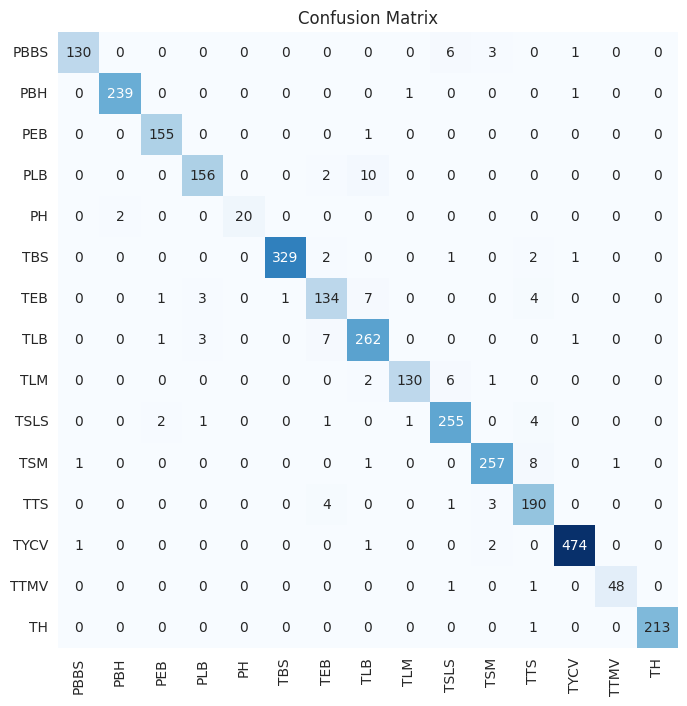

Test Classification Report:
               precision    recall  f1-score   support

        PBBS       0.98      0.93      0.96       140
         PBH       0.99      0.99      0.99       241
         PEB       0.97      0.99      0.98       156
         PLB       0.96      0.93      0.94       168
          PH       1.00      0.91      0.95        22
         TBS       1.00      0.98      0.99       335
         TEB       0.89      0.89      0.89       150
         TLB       0.92      0.96      0.94       274
         TLM       0.98      0.94      0.96       139
        TSLS       0.94      0.97      0.96       264
         TSM       0.97      0.96      0.96       268
         TTS       0.90      0.96      0.93       198
        TYCV       0.99      0.99      0.99       478
        TTMV       0.98      0.96      0.97        50
          TH       1.00      1.00      1.00       214

    accuracy                           0.97      3097
   macro avg       0.97      0.96      0.96      30

In [18]:
# Parameters
random_seed = 42
num_classes = len(leaf_datasets.classes)
torch.manual_seed(random_seed)

# Total dataset size
total_size = len(leaf_datasets)

# Compute exact sizes
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # ensures sum matches exactly

# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(leaf_datasets, [train_size, val_size, test_size])

print("Train size:", train_size)
print("Validation size:", len(valid_dataset))
print("Test size:", len(test_dataset))

# Create DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8),
    'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
}
# Create model
model = XceptionModel(num_classes)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

# Optimizer, loss, scheduler
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training setup
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
num_epochs = 15

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

val_true_labels = []
val_pred_labels = []

since = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(dev), labels.to(dev)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_true_labels.clear()
    val_pred_labels.clear()

    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(dev), labels.to(dev)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(preds.cpu().numpy())

    val_loss = val_loss / len(dataloaders['valid'].dataset)
    val_acc = val_corrects.double() / len(dataloaders['valid'].dataset)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    scheduler.step()

# End of training
time_elapsed = time.time() - since
print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best Validation Accuracy: {best_acc:.4f}")

# Save best model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_model.pth")
print("Best model saved as 'best_model.pth'")
# Final evaluation on test set
model.eval()
test_true_labels = []
test_pred_labels = []
test_corrects = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(dev), labels.to(dev)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_corrects += torch.sum(preds == labels.data)
        test_true_labels.extend(labels.cpu().numpy())
        test_pred_labels.extend(preds.cpu().numpy())

# Metrics
final_test_acc = test_corrects.double() / len(dataloaders['test'].dataset)
final_test_precision = precision_score(test_true_labels, test_pred_labels, average='weighted')
final_test_recall = recall_score(test_true_labels, test_pred_labels, average='weighted')
final_test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

print("\nTest Accuracy:", final_test_acc)
print("Test Precision:", final_test_precision)
print("Test Recall:", final_test_recall)
print("Test F1 Score:", final_test_f1)

# Confusion Matrix & Report
plot_confusion_matrix(test_true_labels, test_pred_labels, leaf_datasets.classes)
test_report = classification_report(test_true_labels, test_pred_labels, target_names=leaf_datasets.classes)
print("Test Classification Report:\n", test_report)

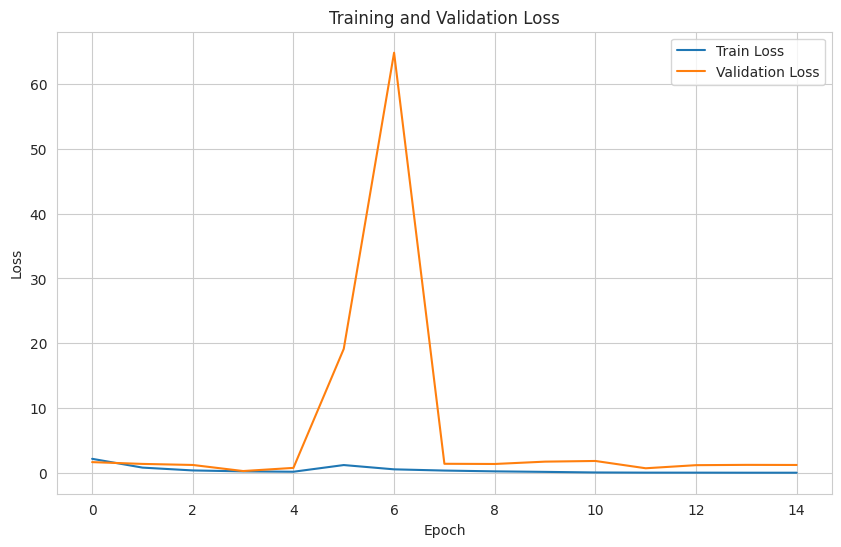

In [20]:


plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("loss_plot.png")
plt.show(block=True)


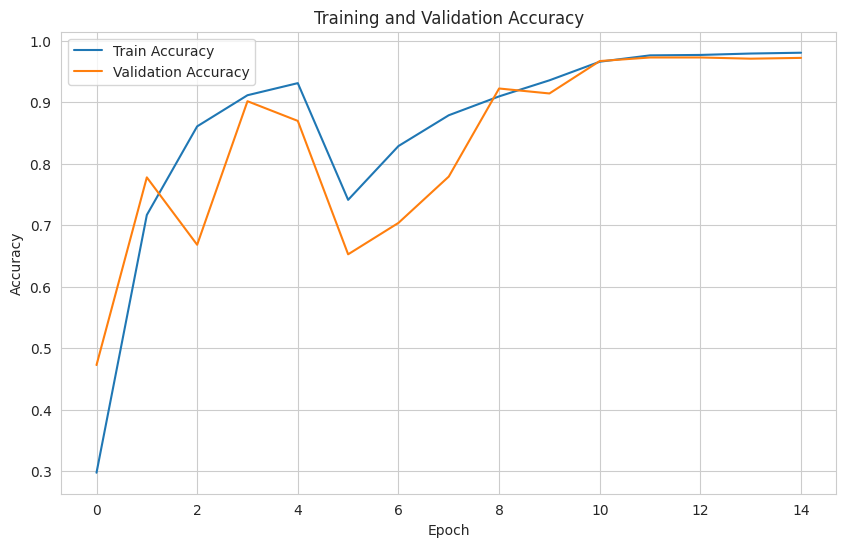

In [21]:
import matplotlib.pyplot as plt

# Convert to tensors if needed (optional)
train_acc_tensor = torch.tensor(train_acc_list)
val_acc_tensor = torch.tensor(val_acc_list)

plt.figure(figsize=(10, 6))
plt.plot(train_acc_tensor, label="Train Accuracy")
plt.plot(val_acc_tensor, label="Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.savefig("accuracy_plot.png")
plt.show()


In [22]:
val_report = classification_report(val_true_labels, val_pred_labels, target_names=leaf_datasets.classes)
print("Classification Report:\n", val_report)

Classification Report:
               precision    recall  f1-score   support

        PBBS       0.97      0.96      0.96       156
         PBH       1.00      0.99      1.00       219
         PEB       1.00      0.99      1.00       157
         PLB       0.96      0.98      0.97       136
          PH       1.00      1.00      1.00        23
         TBS       0.97      1.00      0.99       290
         TEB       0.91      0.89      0.90       139
         TLB       0.98      0.94      0.96       282
         TLM       0.98      0.95      0.97       146
        TSLS       0.95      0.95      0.95       262
         TSM       0.97      0.98      0.98       243
         TTS       0.95      0.96      0.96       216
        TYCV       1.00      0.99      0.99       515
        TTMV       0.81      0.97      0.88        63
          TH       1.00      0.99      0.99       248

    accuracy                           0.97      3095
   macro avg       0.96      0.97      0.97      3095
we

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


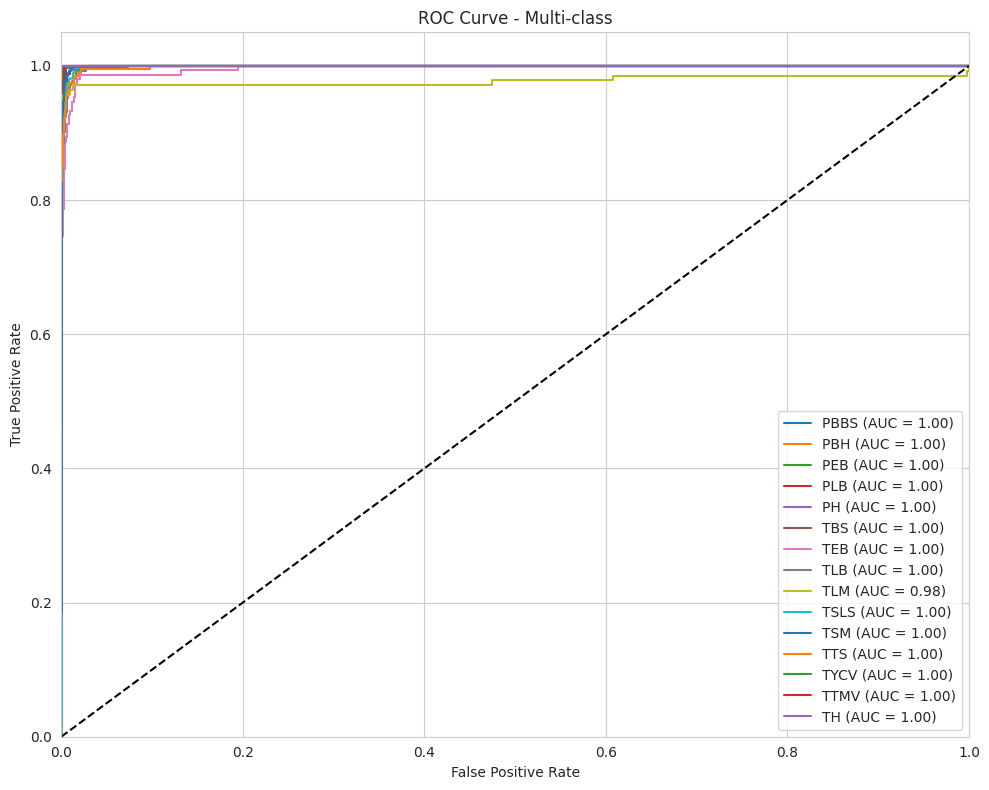

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Compute probability scores for ROC
all_probs = []
model.eval()
with torch.no_grad():
    for inputs, _ in dataloaders['test']:
        inputs = inputs.to(dev)
        outputs = model(inputs)  # logits
        probs = nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# Convert to NumPy arrays
all_probs = np.array(all_probs)
y_true_bin = label_binarize(test_true_labels, classes=range(num_classes))

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{leaf_datasets.classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()
